## Init

In [89]:
import numpy as np
from matplotlib import pyplot as plt

samples = 2 ** 8
drift = 0.5
xmin, xmax = -20, 20
ymin, ymax = -20, 20
zmin, zmax = -20, 20
rhomin, rhomax = 0,10
phimin, phimax = -np.pi, np.pi

phirange = np.linspace(phimin, phimax, num=samples)
rhorange = np.linspace(rhomin, rhomax, num=samples)
xrange = np.linspace(xmin, xmax, num=samples)
yrange = np.linspace(ymin, ymax, num=samples)
zrange = np.linspace(zmin, zmax, num=samples)

dx = xrange[1] - xrange[0]
dy = yrange[1] - yrange[0]
dz = zrange[1] - zrange[0]
dphi = phirange[1] - phirange[0]
drho = rhorange[1] - rhorange[0]

x, y = np.meshgrid(xrange, yrange)
x, z = np.meshgrid(xrange, zrange)

zero = np.zeros_like(x)
phi = np.atan2(y, x)
r = np.sqrt(x**2 + y**2)

orts_vecXY = np.array([x, y]) # ortsvektor (x,y)
orts_vecXZ = np.array([x, z]) # ortsvektor (x,z)
# Plot Initialization
fig = plt.figure(figsize=[5,5])
#ax = fig.add_axes([1,1,1,1])

<Figure size 500x500 with 0 Axes>

## Helperfunctions

In [90]:
def integral(integrant,range, shape):
    out = np.zeros(shape)
    dx = range[1] - range[0]
    for x in range:
        out += integrant(x)*dx
    return out
    

def plot3dVectField(points, arrows, n_arrows=5,scale=1):
    div = samples//n_arrows
    plt.quiver(points[0][::div,::div], points[1][::div,::div], arrows[0][::div,::div],arrows[1][::div,::div], scale=scale)
    plt.show()

# Magnetostatisches Feld eines Linienstroms

$$ \vec{r'} = \begin{bmatrix} 
                v_1 \\ 
                v_2 \\ 
                v_3 
            \end{bmatrix}
 $$

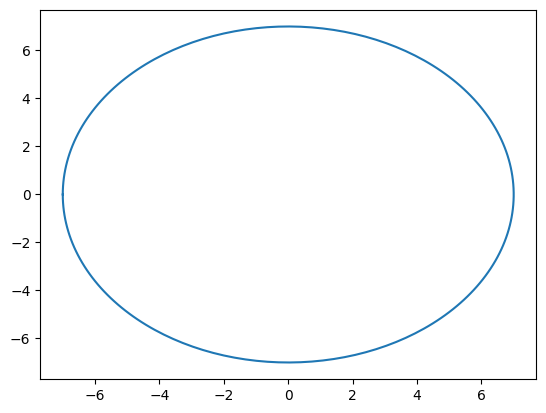

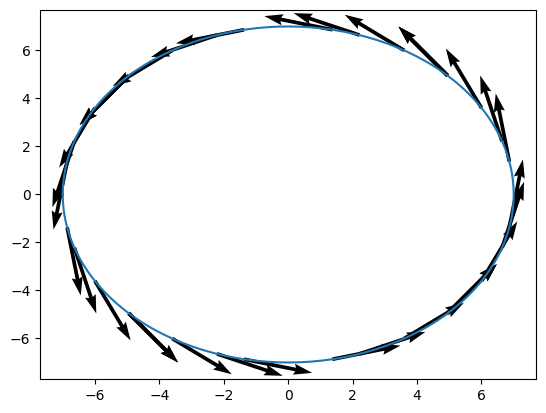

In [91]:
R = 7 # = Radius des Stroms
I = 3

def r(_phi, R): # Orts Kurve
    return R*np.array([np.cos(_phi), np.sin(_phi), np.zeros_like(_phi)])

def j(_phi, R, I): # Stromdichte 
    return I*R*np.array([-np.sin(_phi), np.cos(_phi), np.zeros_like(_phi)])

stromdichte_x, stromdichte_y ,stromdichte_z = j(phi,R,I)
ortskurve_X, ortskurve_Y, ortskurve_Z = r(phi, R)

kurve_x, kurve_y, _ = r(phirange, R)
[plt.plot(kurve_x, kurve_y),plt.show(),plt.plot(kurve_x, kurve_y)]
plot3dVectField([ortskurve_X, ortskurve_Y], [stromdichte_x, stromdichte_y], n_arrows=5, scale=150)

# Feld auf der Z - Achse (zx ebene)

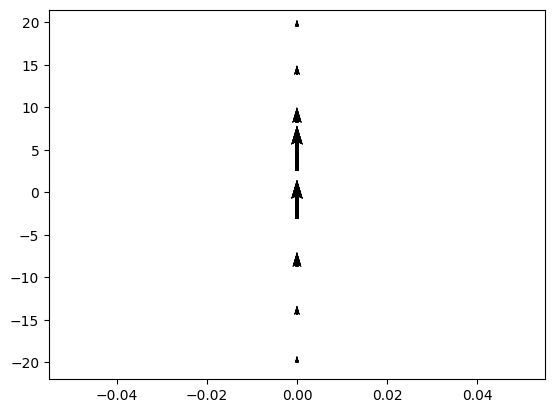

In [92]:
scalar = (2*np.sqrt(1+z**2))**-1
field_on_axis = np.array([zero,zero,scalar])
plot3dVectField([zero,z],[field_on_axis[0], field_on_axis[2]], n_arrows=7, scale=2)

# Potenzial

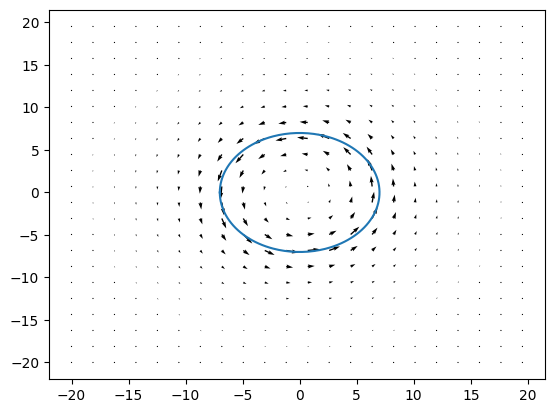

In [93]:
plt.plot(kurve_x,kurve_y)
def potenzial(r,j):
    def potenzial_integrant(_phi):
        curveN_x, curveN_y, curveN_z = r(_phi) # Ortsvektor auf der Stromkurve
        stromdichteN_x, stromdichteN_y, stromdichteN_z = j(_phi) # Stromdichte auf der Stromkurve
        distance = drift+np.sqrt((x-curveN_x)**2+(y-curveN_y)**2+(curveN_z)**2)
        return np.array([stromdichteN_x/distance,stromdichteN_y/distance])
    return integral(potenzial_integrant, phirange, orts_vecXY.shape)

circuit_potential = potenzial(lambda phi:r(phi,R),lambda phi:j(phi,R,I))
plot3dVectField([x,y],circuit_potential,n_arrows=20,scale=500)

# Feld


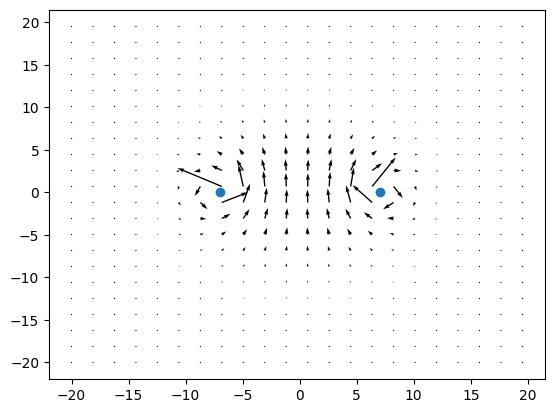

In [94]:
plt.scatter([-R,R],[0,0])

def field(_r,_j,parameter_range):
    def field_integrant(_phi):
        curveN_x, curveN_y, curveN_z = _r(_phi) # Ortsvektor auf der Stromkurve
        to_point = np.array([x-curveN_x, zero-curveN_y, z-curveN_z])
        distance = np.linalg.norm(to_point,axis=0)
        cr_x,cr_y,cr_z = np.cross(_j(_phi), to_point, axis=0)
        return np.array([cr_x/distance**3, cr_z/distance**3])
    return integral(field_integrant, parameter_range, orts_vecXZ.shape)

circuit_field = field(lambda _phi: r(_phi,R), lambda _phi: j(_phi,R,I),phirange)
plot3dVectField([x,z],circuit_field,n_arrows=20,scale=100)

## Spule


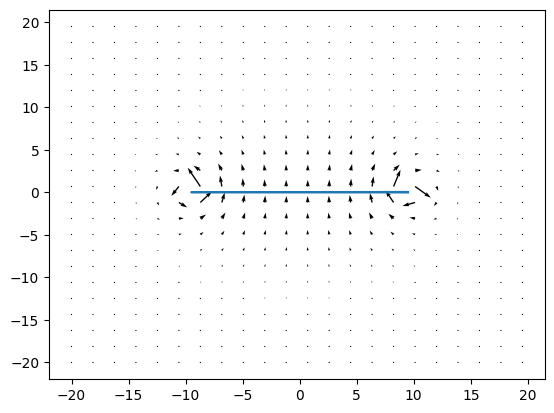

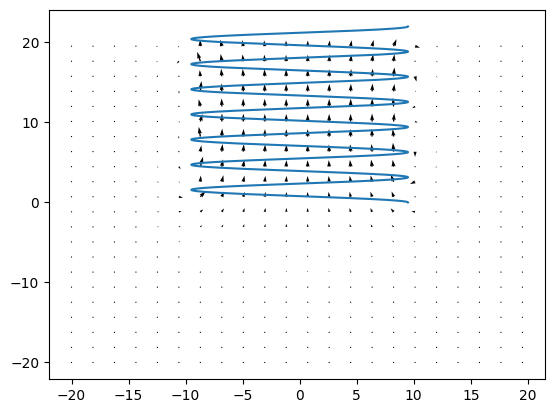

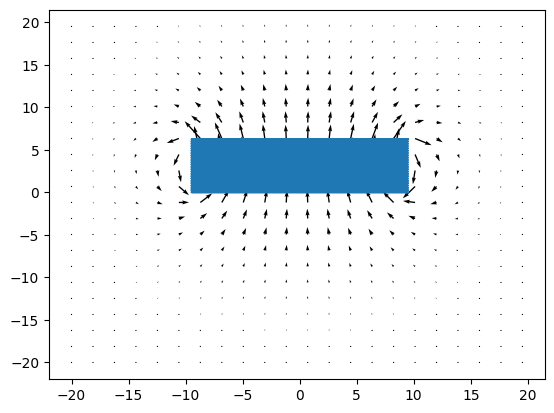

In [113]:
def spulenPlot(windungen= 100,steepness=0.1,_R=1,scale=3000,I=1,detail=20 ):
    longer_phi = np.linspace(0, 2*np.pi*windungen, num=samples*4)
    def spule(_phi):
        return np.array([_R*np.cos(_phi),_R*np.sin(_phi),_phi*steepness])
    def j_spule(_phi):
        return np.array([-_R*I*np.sin(_phi),_R*I*np.cos(_phi),I*steepness])

    kurve = spule(longer_phi)
    plt.plot(kurve[0], kurve[2])
    field_spule = field(spule,j_spule,longer_phi)
    plot3dVectField([x,z],field_spule,n_arrows=detail,scale=scale)
R = 9.5 # krumme zahl damit
spulenPlot(1,0.01,R, 50)
spulenPlot(7,0.5,R, 200)
spulenPlot(100,0.01,R, 2000)



### $R-> 0$ und $R^2*I=Konst$
#### Analytische Lösung

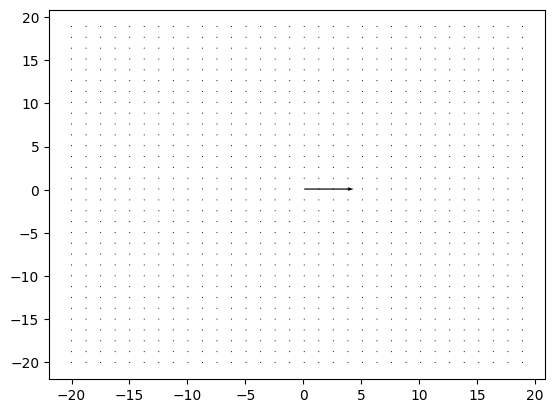

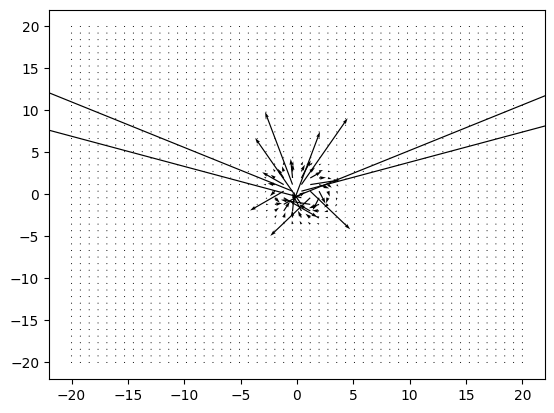

In [114]:
K = 1
abs_r = np.sqrt(x**2+y**2+z**2)
fern_field = np.array([3*x*z,3*y*z, 2*abs_r**2-6*x*y])/(4*abs_r**5)
#fern_field = np.array([zero+1,y*z,2-x*y])
plot3dVectField([x,z],[fern_field[0],fern_field[2]],n_arrows=30,scale=1000)

spulenPlot(1,0,0.01, 20,I=10000,detail=51)

## 1 Analytische Lösung

Idealisierungen:
* unendlich dünner Leiter
* ringförmiger Leiter
* endlicher Radius
* Bestimmung des magnetischen Potenzials und des magnetischen Feldes nur auf der Symmetrieachse. (Sven)

### 1.1 Herleitung

* siehe Vorlesung
* magnetisches Potenzial
* magnetisches Feld
* in Zylinderkoordinaten
* Lösung auf der Achse in möglichst einfacher Form


**Poisson-Gleichung**
$$
\Delta \vec{A} = -\mu \vec{j}
$$

**Lösung**
$$
\vec{A}(\vec{r}) = \frac{\mu}{4\pi} \iiint \frac{\vec{j}(\vec{r}')}{|\vec{r} - \vec{r}'|} dV'
$$

Der Strom verläuft auf einer Kreisbahn mit Radius $R$. Die Kurve kann durch $\vec{r}(\varphi) = \begin{pmatrix} R \cos(\varphi) \\ R \sin(\varphi) \\ 0 \end{pmatrix}$ beschrieben werden. Die Stromdichte ist konstant und beträgt $I$.

Um das Magnetische Potenzial $\vec{A}$ zu berechnen, müssen wir für jeden Punkt im Raum die durchschnittliche Flussrichtung des Stroms gewichtet mit dem kehrwert des Abstandes berechnen. Dazu integrieren wir über die gesamte Kreisbahn.

$\vec{A}= \frac{\mu_0}{4\pi} \int_0^{2\pi} \frac{I}{R} \begin{pmatrix} -\sin(\varphi) \\ \cos(\varphi) \\ 0 \end{pmatrix} d\varphi$



### 1.2 Visualisierung

* magnetisches Potenzial
* $z$-Komponente des magnetischen Feldes

## 2 Numerische Lösung

### 2.1 Herleitung

* Formeln zur numerischen Berechnung in beliebigem Raumpunkt
    * magnetisches Potenzial: aus der Quellendarstellung
    * magnetisches Feld: aus dem Potenzial
* alles in Zylinderkoordinaten
* Rotationssymmetrie ausnutzen

### 2.2 Berechnung

* Wahl des Integrationsverfahrens
* Wahl des Samplings

### 2.3 Visualisierung

* magnetisches Potenzial
* alle Komponenten des magnetischen Feldes (Raphael)
* alles in Zylinderkoodinaten
* Rotationssymmetrie ausnutzen
* geeignete zweidimensionale Schnitte (zx achse y=0 y=-3)
* freie Wahl der Bibliothek zum Plotten
    * [Matplotlib](https://matplotlib.org/)
    * [Seaborn](https://seaborn.pydata.org/)
    * [Plotly](https://plotly.com/)
    * [Bokeh](https://bokeh.org/)
    * ...

## 3 Vergleich analytische und numerische Lösung

* Bestimmung des relativen Fehlers
* auf der Symmetrieachse
* magnetisches Potenzial
* $z$-Komponente des magnetischen Feldes
* Visualisierung wie bei der analytischen Lösung
* logarithmisch darstellen

## 4 Verallgemeinerung

* Spule
    * $N$ Windungen
    * Länge $L$
* magnetisches Potenzial und magnetisches Feld
* Vorgehen bei numerischer Berechnung und Visualisierung wie oben

### Fakultativ
* Ringstrom
    * Recherche analytische Lösung (falls möglich, kann kompliziert werden!)
    * Grenzübergang $R\to0$ und Vergleich mit infinitesimalem magnetischem Dipol
        * analytisch
        * numerisch
* Spule
    * Vergleich mit $N$ im Abstand $L/N$ aneinandergereihten Kreisströmen
    * Vergleich mit anderem Team: zylindrischer Permanentmagnet

## 5 Ausblick:  Zeitlich veränderlicher Strom

Idealisierungen:
* unendlich dünner Leiter
* ringförmiger Leiter
* endlicher Radius
* Bestimmung des magnetischen Potenzials und des magnetischen Feldes nur auf der Symmetrieachse.

Verallgemeinerung: *zeitlich veränderlicher* Strom
* quasistatischer Fall
* dynamischer Fall

Nur eine kurze Beschreibung dessen, was zur Bestimmung des zeitlich veränderlichen magnetischen Feldes zu tun wäre - insbesondere ein paar Worte zu den erwarteten Hürden in Bezug auf:
* Zeitkomplexität
* Speicherbedarf
* Genauigkeit